## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

### 之前做過的處理

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

In [3]:
app_train.dtypes

SK_ID_CURR                                    int64
TARGET                                        int64
NAME_CONTRACT_TYPE                            int32
FLAG_OWN_CAR                                  int32
FLAG_OWN_REALTY                               int32
CNT_CHILDREN                                  int64
AMT_INCOME_TOTAL                            float64
AMT_CREDIT                                  float64
AMT_ANNUITY                                 float64
AMT_GOODS_PRICE                             float64
REGION_POPULATION_RELATIVE                  float64
DAYS_BIRTH                                    int64
DAYS_EMPLOYED                               float64
DAYS_REGISTRATION                           float64
DAYS_ID_PUBLISH                               int64
OWN_CAR_AGE                                 float64
FLAG_MOBIL                                    int64
FLAG_EMP_PHONE                                int64
FLAG_WORK_PHONE                               int64
FLAG_CONT_MO

In [4]:
# 這些變項數值比較連續，可以試著畫KDE

app_train.nunique()[app_train.nunique() > 50]

SK_ID_CURR                      307511
AMT_INCOME_TOTAL                  2548
AMT_CREDIT                        5603
AMT_ANNUITY                      13672
AMT_GOODS_PRICE                   1002
REGION_POPULATION_RELATIVE          81
DAYS_BIRTH                       17460
DAYS_EMPLOYED                    12573
DAYS_REGISTRATION                15688
DAYS_ID_PUBLISH                   6168
OWN_CAR_AGE                         62
EXT_SOURCE_1                    114584
EXT_SOURCE_2                    119831
EXT_SOURCE_3                       814
APARTMENTS_AVG                    2339
BASEMENTAREA_AVG                  3780
YEARS_BEGINEXPLUATATION_AVG        285
YEARS_BUILD_AVG                    149
COMMONAREA_AVG                    3181
ELEVATORS_AVG                      257
ENTRANCES_AVG                      285
FLOORSMAX_AVG                      403
FLOORSMIN_AVG                      305
LANDAREA_AVG                      3527
LIVINGAPARTMENTS_AVG              1868
LIVINGAREA_AVG           

### AMT_INCOME_TOTAL

In [5]:
# 整體收入 AMT_INCOME_TOTAL

# 平均切割收入可以到有很明顯的極端值出現

g1 = pd.cut(app_train['AMT_INCOME_TOTAL'], 4)
print(g1.value_counts())
print('\r\n')

# 用 qcut 後發現數量不同，是因為同樣的金額的數量很多(可以從app_train.AMT_INCOME_TOTAL.value_counts()看到)
g2 = pd.qcut(app_train['AMT_INCOME_TOTAL'], 4)
print(g2.value_counts())

# 最後選定用百分位數切割
app_train['AIT_group'] = g2

# AMT_INCOME_TOTAL 不適合畫KDE

(-91324.35, 29269237.5]      307510
(87756412.5, 117000000.0]         1
(58512825.0, 87756412.5]          0
(29269237.5, 58512825.0]          0
Name: AMT_INCOME_TOTAL, dtype: int64


(25649.999, 112500.0]      100578
(147150.0, 202500.0]        82213
(202500.0, 117000000.0]     71538
(112500.0, 147150.0]        53182
Name: AMT_INCOME_TOTAL, dtype: int64


### DAYS_EMPLOYED

(2, 6]      92744
(0, 2]      59825
(6, 10]     48612
(10, 20]    38398
(20, 50]    12556
Name: DAYS_EMPLOYED, dtype: int64


(-0.001, 1.69]      50511
(10.071, 49.074]    50428
(1.69, 3.425]       50409
(5.918, 10.071]     50399
(3.425, 5.918]      50390
Name: DAYS_EMPLOYED, dtype: int64


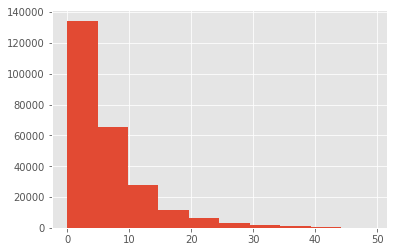

In [6]:

# DAYS_EMPLOYED -> YEARS_EMPLOYED

(app_train['DAYS_EMPLOYED']/-365.0).hist()


# 以年作為單位觀察被雇用的長度，可以發現2~6年的年資區間包含最多人
g1 = pd.cut(-app_train[~app_train.DAYS_EMPLOYED.isna()]['DAYS_EMPLOYED']/365.0,[0,2,6,10,20,50])
print(g1.value_counts())
print('\r\n')

# 改用百分位數做為切割方式，間隔大概為 0-1.7 1.7-3.4 3.4-5.9 5.9-10.1 10.1-49
g2 = pd.qcut(-app_train[~app_train.DAYS_EMPLOYED.isna()]['DAYS_EMPLOYED']/365.0,5)
print(g2.value_counts())

# 跟百分位數差異不大，因此遵照原先想的切割方式
app_train['DE_group'] = pd.qcut(app_train['DAYS_EMPLOYED']/365.0,5)

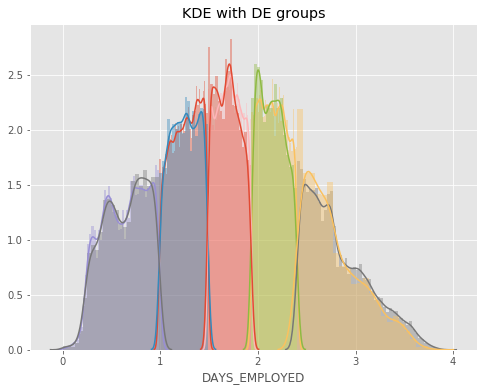

In [7]:
plt.figure(figsize=(8,6))

DE_group = app_train['DE_group'].unique()

for i in range(len(DE_group)):
    sns.distplot(np.log1p(app_train.loc[(app_train['DE_group'] == DE_group[i]) & \
                              (app_train['TARGET'] == 0), 'DAYS_EMPLOYED']/-365.0), label = str(DE_group[i]))
    
    sns.distplot(np.log1p(app_train.loc[(app_train['DE_group'] == DE_group[i]) & \
                              (app_train['TARGET'] == 1), 'DAYS_EMPLOYED']/-365.0), label = str(DE_group[i]))
plt.title('KDE with DE groups')
plt.show()

### EXT_SOURCE_3

In [8]:
# EXT_SOURCE_3 -> 之前計算相關最高的變項之一

g2 = pd.qcut(app_train[~app_train.EXT_SOURCE_3.isna()]['EXT_SOURCE_3'],5)
print(g2.value_counts())

app_train['ES3_group'] = pd.qcut(app_train['EXT_SOURCE_3'],5)

(0.33, 0.476]        49746
(0.476, 0.592]       49578
(0.592, 0.694]       49470
(-0.000473, 0.33]    49445
(0.694, 0.896]       48307
Name: EXT_SOURCE_3, dtype: int64


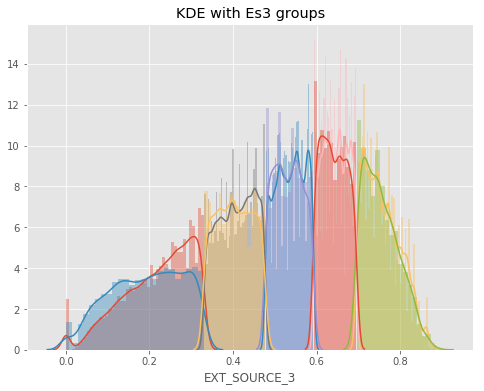

In [9]:
#可以發現到ES3分數低的時候target=0 & target=1 的 KDE長相較不同

plt.figure(figsize=(8,6))

ES3_group = app_train['ES3_group'].unique()

for i in range(len(ES3_group)):
    sns.distplot(app_train.loc[(app_train['ES3_group'] == ES3_group[i]) & \
                              (app_train['TARGET'] == 0), 'EXT_SOURCE_3'], label = str(ES3_group[i]))
    
    sns.distplot(app_train.loc[(app_train['ES3_group'] == ES3_group[i]) & \
                              (app_train['TARGET'] == 1), 'EXT_SOURCE_3'], label = str(ES3_group[i]))
plt.title('KDE with Es3 groups')
plt.show()